In [1]:
import functions_ml as fml
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

/home/lucasmalheiros/Documents/Pesquisa Operacional/tcc-relax-and-fix/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train

In [2]:
results = pd.read_csv('datasets/instances_results.csv')
features = pd.read_csv('datasets/multi_plant_instance_features.csv')
dataset = fml.create_dataset(features, results)

In [3]:
dataset = fml.create_binary_target(dataset, tolerance=0.01/100)
dataset[['TARGET']].value_counts()

TARGET
GroupA    307
GroupB    291
Name: count, dtype: int64

In [4]:
X = dataset.drop(columns=['TARGET', 'instance'])
y = dataset['TARGET']

In [5]:
# Creating the Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=2112)

# Create Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2112)

# Evaluate model using cross-validation
f1_scorer = make_scorer(f1_score, pos_label='GroupA')
f1_scores = cross_val_score(classifier, X, y, cv=cv, scoring=f1_scorer)
print("Cross-Validated F1 Scores:", f1_scores)
print("Mean F1 Score:", f"{np.mean(f1_scores):.4f}")

Cross-Validated F1 Scores: [0.72727273 0.81967213 0.875      0.93548387 0.82539683 0.80645161
 0.83076923 0.79365079 0.83333333 0.86153846]
Mean F1 Score: 0.8309


In [6]:
# Optional: Cross-validation predictions for confusion matrix and other metrics
predictions = cross_val_predict(classifier, X, y, cv=cv)

# Evaluate metrics based on cross-validated predictions
accuracy = accuracy_score(y, predictions)
precision = precision_score(y, predictions, pos_label='GroupA')
recall = recall_score(y, predictions, pos_label='GroupA')
f1 = f1_score(y, predictions, pos_label='GroupA')
matrix = confusion_matrix(y, predictions)

# Output performance metrics
print(f"Cross-Validated Accuracy: {accuracy:.4f}")
print(f"Cross-Validated Precision: {precision:.4f}")
print(f"Cross-Validated Recall: {recall:.4f}")
print(f"Cross-Validated F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", matrix)

Cross-Validated Accuracy: 0.8261
Cross-Validated Precision: 0.8243
Cross-Validated Recall: 0.8404
Cross-Validated F1 Score: 0.8323
Confusion Matrix:
 [[258  49]
 [ 55 236]]


# Explain

In [7]:
# Train on all data
classifier.fit(X, y)

RandomForestClassifier(random_state=2112)

## Permutation importance

                     Feature  Importance
25          total_setup_cost    0.013608
27            std_setup_cost    0.009399
12             kurt_capacity    0.002279
9               max_capacity    0.001626
40           max_utilization    0.001302
8               avg_capacity    0.001301
39           avg_utilization    0.001301
38           min_utilization    0.000979
1                 num_plants    0.000979
7               min_capacity    0.000979
11             skew_capacity    0.000653
33  kurt_transportation_cost    0.000653
41           std_utilization    0.000650
43          kurt_utilization    0.000326
31   std_transportation_cost    0.000326
30   avg_transportation_cost    0.000326
18            std_setup_time    0.000326
26            avg_setup_cost    0.000325
32  skew_transportation_cost    0.000325
3                 avg_demand    0.000000


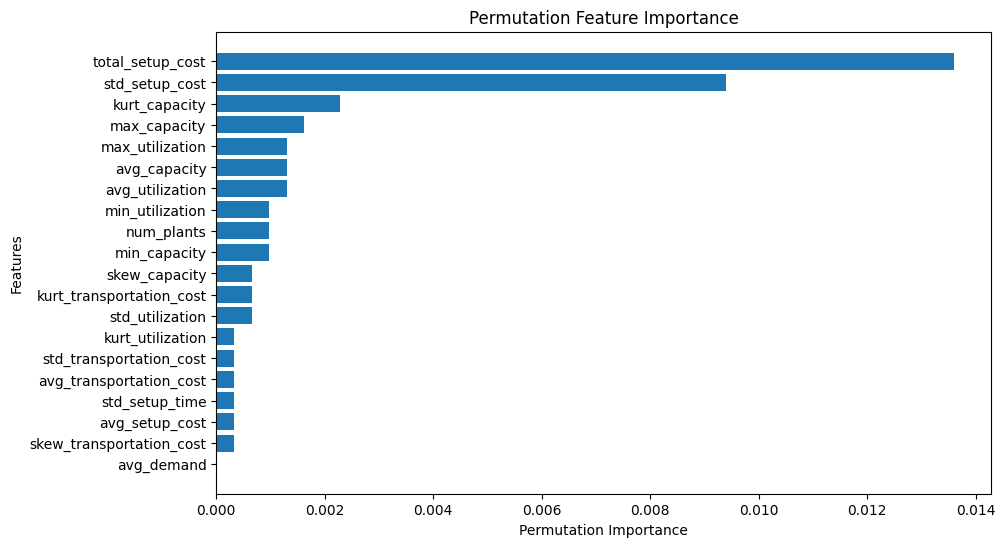

In [8]:
# Compute permutation importance
f1_scorer = make_scorer(f1_score, pos_label='GroupA')
perm_importance = permutation_importance(classifier, X, y, scoring=f1_scorer, random_state=2112)

# Create a DataFrame for readability
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

importances = importances.head(20)
print(importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importance")
plt.show()

## Random forest features

In [9]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)
importances.head(30)

,Feature,Importance
25,total_setup_cost,0.083014
12,kurt_capacity,0.060863
27,std_setup_cost,0.058837
32,skew_transportation_cost,0.056677
1,num_plants,0.055354
33,kurt_transportation_cost,0.052848
30,avg_transportation_cost,0.052011
26,avg_setup_cost,0.048474
40,max_utilization,0.030802
38,min_utilization,0.030424


                     Feature  Importance
25          total_setup_cost    0.083014
12             kurt_capacity    0.060863
27            std_setup_cost    0.058837
32  skew_transportation_cost    0.056677
1                 num_plants    0.055354
33  kurt_transportation_cost    0.052848
30   avg_transportation_cost    0.052011
26            avg_setup_cost    0.048474
40           max_utilization    0.030802
38           min_utilization    0.030424
29           kurt_setup_cost    0.030277
41           std_utilization    0.029136
10              std_capacity    0.028630
42          skew_utilization    0.027427
7               min_capacity    0.026996
31   std_transportation_cost    0.025733
9               max_capacity    0.025585
2                binary_vars    0.024815
43          kurt_utilization    0.022539
8               avg_capacity    0.020532


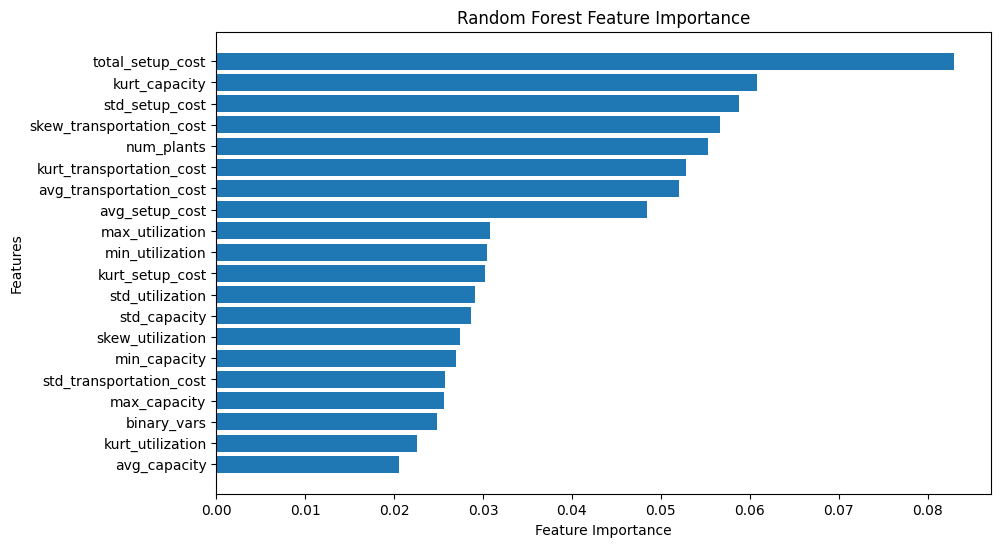

In [10]:
# Extract feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

importances = importances.head(20)
print(importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()

## Partial dependence plots

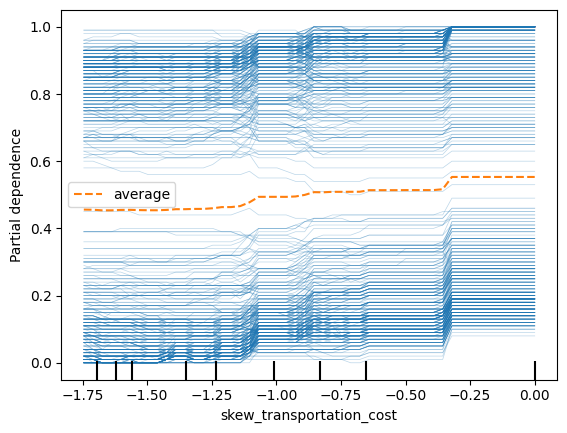

In [11]:
PartialDependenceDisplay.from_estimator(classifier, X, features=['skew_transportation_cost'], kind="both", grid_resolution=50)
plt.show()

## SHAP

In [12]:
# Initialize SHAP explainer for Tree-based models
explainer = shap.TreeExplainer(classifier)

# Compute SHAP values for all classes
shap_values = explainer.shap_values(X)

# Extract SHAP values for the positive class ('GroupA')
shap_values_binary = shap_values[:, :, 0]  # Focus on class 1

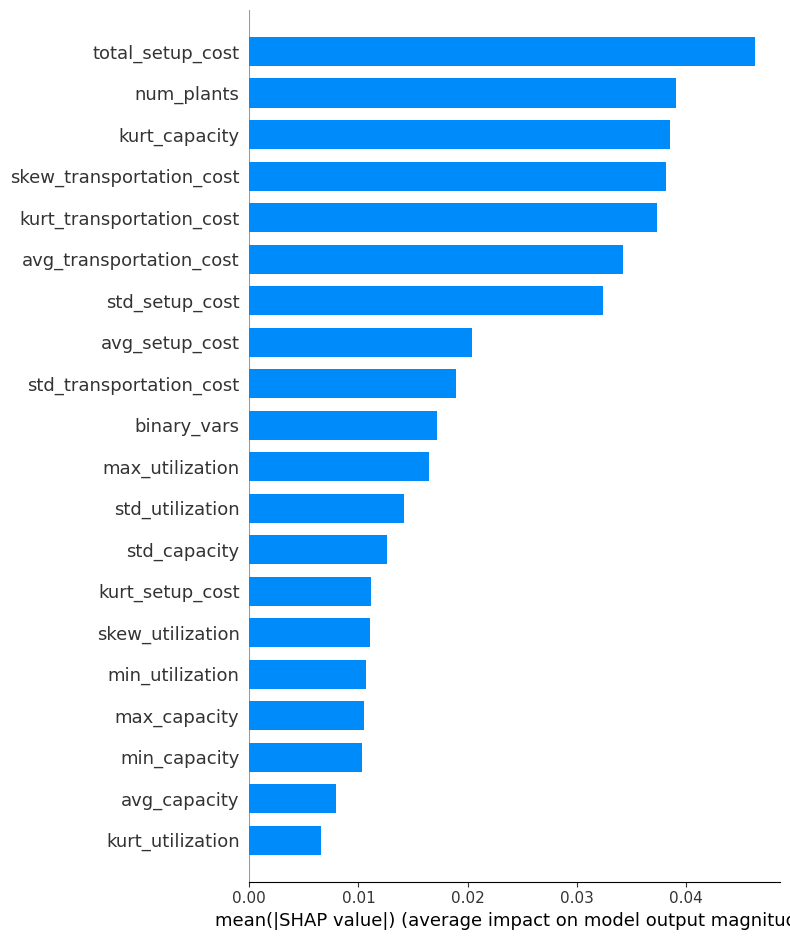

In [13]:
# 1. Summary Plot (Bar Chart for Global Feature Importance)
shap.summary_plot(shap_values_binary, X, plot_type="bar")

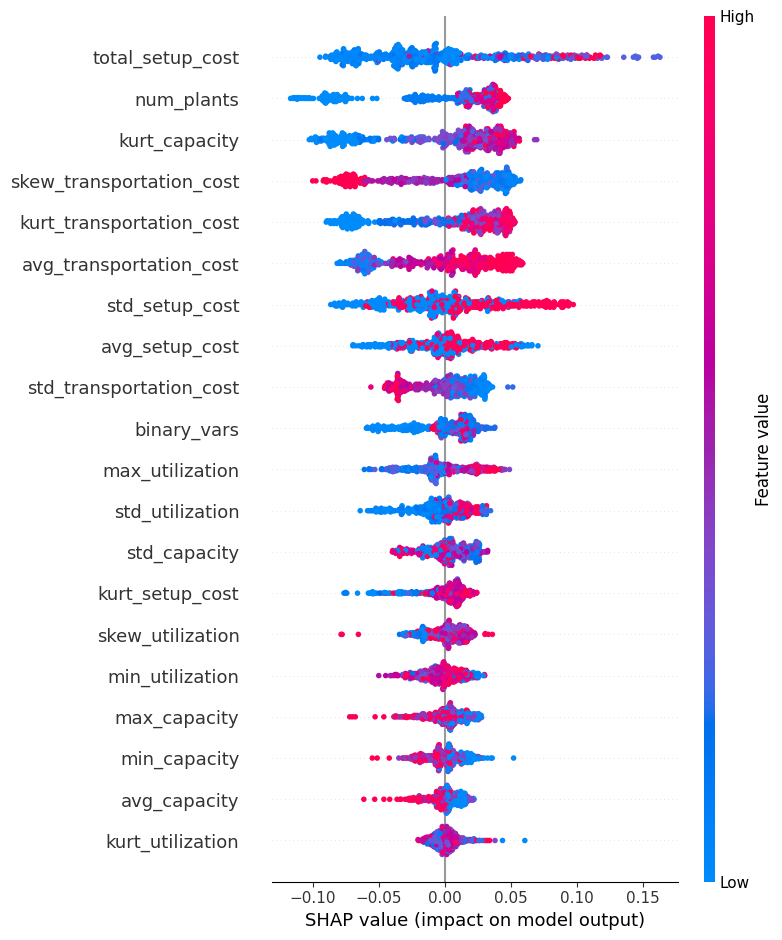

In [14]:
# 2. Beeswarm Plot (Detailed Feature Impact Across Predictions)
shap.summary_plot(shap_values_binary, X)

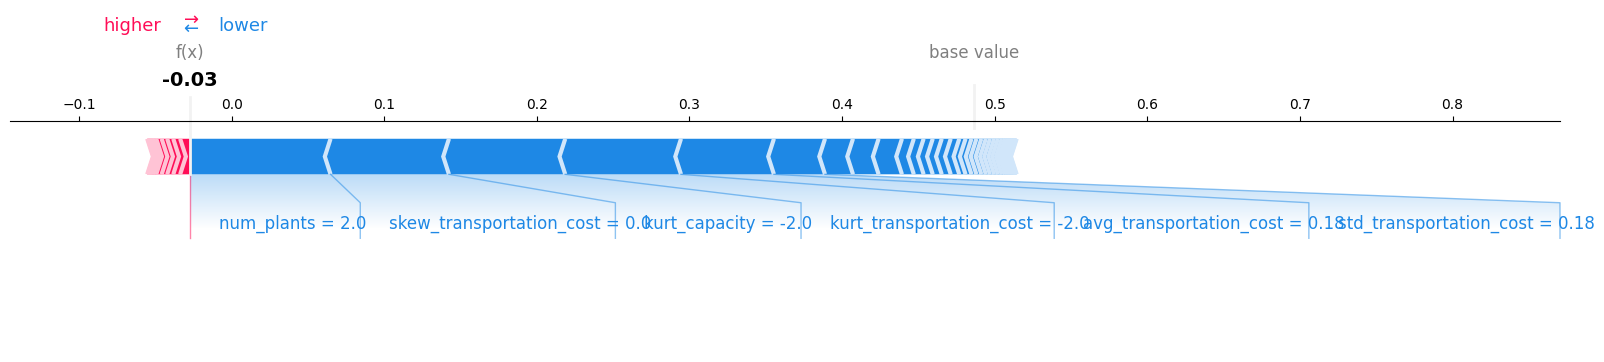

In [15]:
# 3. Single Instance Explanation (Force Plot)
sample_index = 0  # Example: First instance
shap.force_plot(
    explainer.expected_value[1], shap_values_binary[sample_index, :], X.iloc[sample_index, :],
    matplotlib=True
)